In [1]:
!pip install apriori_python efficient-apriori fpgrowth_py pyarmviz numpy pandas matplotlib seaborn  scikit-learn matplotlib umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 658 kB 18.5 MB/s 
     |████████████████████████████████| 88 kB 6.5 MB/s 
     |████████████████████████████████| 1.1 MB 57.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=4089a8f88b33c604a5317d555814f45e2b79ca9c77858afb00de14aaa7613019
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55512 sha256=8928ff41aa1743c5abf87968c52acdd25e590dce21f24fbaf9720f38602b9ed9
  Stored in directory: /root/.cache/pip/wheels/19/bc/eb/974072a56a7082a302f8b4be1ad6d21bf5019235c2eff65928
Successfully built umap-learn pynndescent


In [2]:
import numpy as np
import random
import seaborn as sns
import warnings

import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.manifold import TSNE
from umap import UMAP


warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
def read_data(filename: str, delimeter=';'):
    with open(filename, mode="r", newline='') as f:
        features = list()
        targets = list()
        for row in f:
            line = list()
            for s in row.split(delimeter):
                s = s.strip()
                if s:
                    line.append(s)
            
            t = int(line[-1])
            if t < 3:
                features.append(list(map(float ,line[1:-1])))
                targets.append(t-1)
            if t == 6:
                features.append(list(map(float ,line[1:-1])))
                targets.append(2)
            if t == 7:
                features.append(list(map(float ,line[1:-1])))
                targets.append(3)
    return features, targets

In [ ]:
def make_meshgrid(x, y, h=.02):
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
        return xx, yy

def plot_contours(model, xx, yy, ax, **params):
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_surface(model, xx, yy, ax, **params):
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.plot_surface(xx, yy, Z, **params)
    return out

In [ ]:
def plot_results(features, targets, model, figsize=(10, 5), axis='off', in3d=False, colormap='coolwarm', rot=30):
    xx, yy = make_meshgrid(features[:, 0], features[:, 1])

    fig = plt.figure(figsize=figsize)
    
    if in3d:
        ax = fig.gca(projection='3d')
    else:
        ax = fig.gca()
    
    colormap = colormap
    labels = np.unique(targets).tolist()
    palette = np.array(sns.color_palette(colormap, n_colors=len(labels)))
    cmap = sns.color_palette(colormap, as_cmap=True)


    if in3d:
        plot_surface(model, xx, yy, ax, cmap=cmap, alpha=0.8)
    else:
        plot_contours(model, xx, yy, ax, cmap=cmap, alpha=0.8)
    ax.scatter(features[:, 0], features[:, 1], c=targets, cmap=cmap, s=40, edgecolors='k')
    plt.axis(axis)
    if in3d:
        ax.view_init(40, rot)
    plt.show()

In [ ]:
features, targets = read_data('glass.data', delimeter=',')
features = np.array(features)
targets = np.array(targets)

In [ ]:
print(classification_report(targets, targets))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00        29

    accuracy                           1.00       184
   macro avg       1.00      1.00      1.00       184
weighted avg       1.00      1.00      1.00       184



In [ ]:
np.unique(targets)

array([0, 1, 2, 3])

In [ ]:
smote_features, smote_targets = SMOTE().fit_resample(features, targets)

In [ ]:
print(classification_report(smote_targets, smote_targets))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        76
           3       1.00      1.00      1.00        76

    accuracy                           1.00       304
   macro avg       1.00      1.00      1.00       304
weighted avg       1.00      1.00      1.00       304



In [ ]:
smote_features = UMAP().fit_transform(smote_features)
smote_features = StandardScaler().fit_transform(smote_features)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(smote_features, smote_targets, test_size=0.3, stratify=smote_targets, shuffle=True)
x_train.shape, x_test.shape

((212, 2), (92, 2))

# SVM (SVC)

In [ ]:
svc_parameters = {
    'kernel':['poly', 'rbf', 'sigmoid'],
    'C': np.linspace(1, 10, 11),
    'degree': np.linspace(3, 6, 4)
}

clf_svc = GridSearchCV(SVC(), svc_parameters)

In [ ]:
clf_svc.fit(x_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
                         'degree': array([3., 4., 5., 6.]),
                         'kernel': ['poly', 'rbf', 'sigmoid']})

In [ ]:
clf_svc.best_params_

{'C': 10.0, 'degree': 3.0, 'kernel': 'rbf'}

In [ ]:
print(classification_report(y_train, clf_svc.predict(x_train), digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.738     0.849     0.789        53
           1      0.804     0.698     0.747        53
           2      0.912     0.981     0.945        53
           3      1.000     0.906     0.950        53

    accuracy                          0.858       212
   macro avg      0.864     0.858     0.858       212
weighted avg      0.864     0.858     0.858       212



In [ ]:
print(classification_report(y_test, clf_svc.predict(x_test), digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.800     0.870     0.833        23
           1      0.842     0.696     0.762        23
           2      0.852     1.000     0.920        23
           3      1.000     0.913     0.955        23

    accuracy                          0.870        92
   macro avg      0.873     0.870     0.867        92
weighted avg      0.873     0.870     0.867        92



In [ ]:
best_svc = SVC(**clf_svc.best_params_)

In [ ]:
best_svc.fit(x_train, y_train)

SVC(C=10.0, degree=3.0)

In [ ]:
len(best_svc.support_vectors_)

110

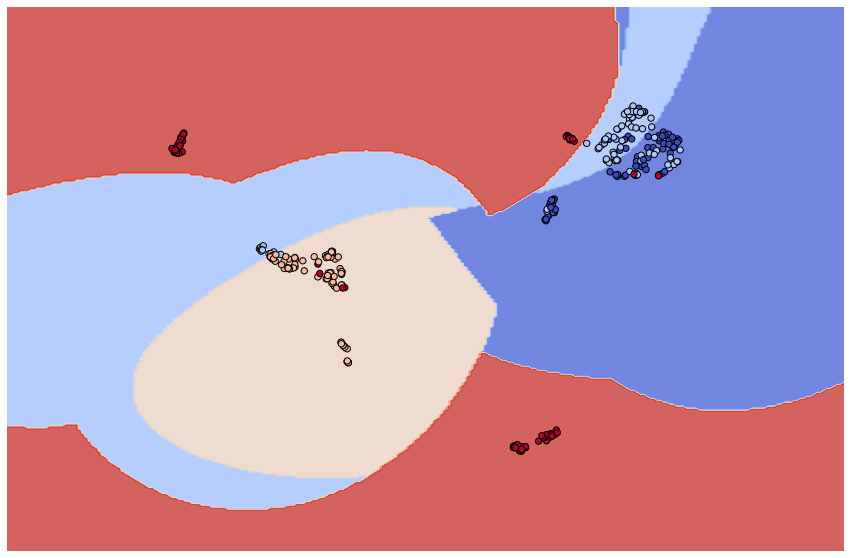

In [ ]:
plot_results(smote_features, smote_targets, best_svc, figsize=(15, 10))

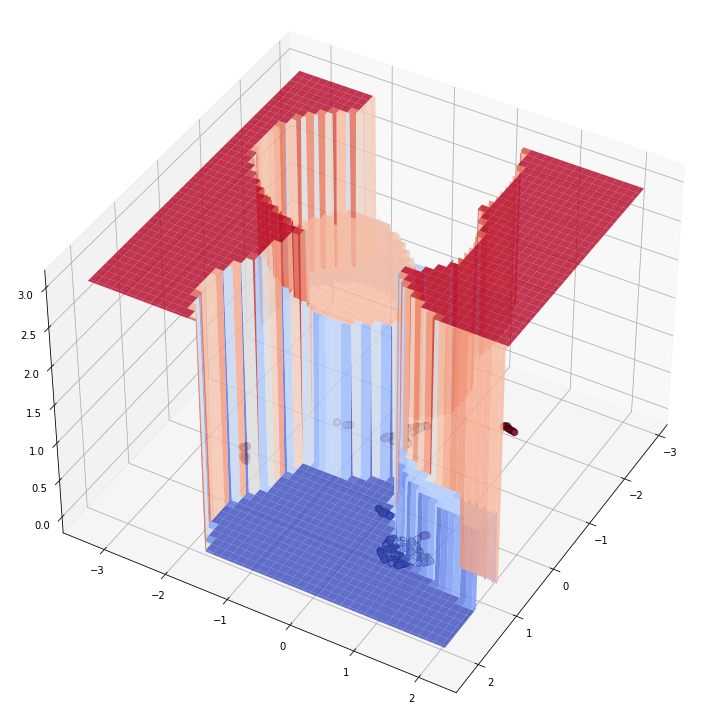

In [ ]:
plot_results(smote_features, smote_targets, best_svc, figsize=(13, 13), in3d=True, axis='on')

# KNN

In [ ]:
knn_parameters = {
    'n_neighbors': np.linspace(5, 15, 10, dtype=np.int32),
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['distance', 'uniform'],
    'p': [1, 2]
}

clf_knn = GridSearchCV(KNeighborsClassifier(), knn_parameters)

In [ ]:
clf_knn.fit(x_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 15]),
                         'p': [1, 2], 'weights': ['distance', 'uniform']})

In [ ]:
clf_knn.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 9, 'p': 2, 'weights': 'distance'}

In [ ]:
print(classification_report(y_train, clf_knn.predict(x_train), digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        53
           1      1.000     1.000     1.000        53
           2      1.000     1.000     1.000        53
           3      1.000     1.000     1.000        53

    accuracy                          1.000       212
   macro avg      1.000     1.000     1.000       212
weighted avg      1.000     1.000     1.000       212



In [ ]:
print(classification_report(y_test, clf_knn.predict(x_test), digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.857     0.783     0.818        23
           1      0.783     0.783     0.783        23
           2      0.852     1.000     0.920        23
           3      1.000     0.913     0.955        23

    accuracy                          0.870        92
   macro avg      0.873     0.870     0.869        92
weighted avg      0.873     0.870     0.869        92



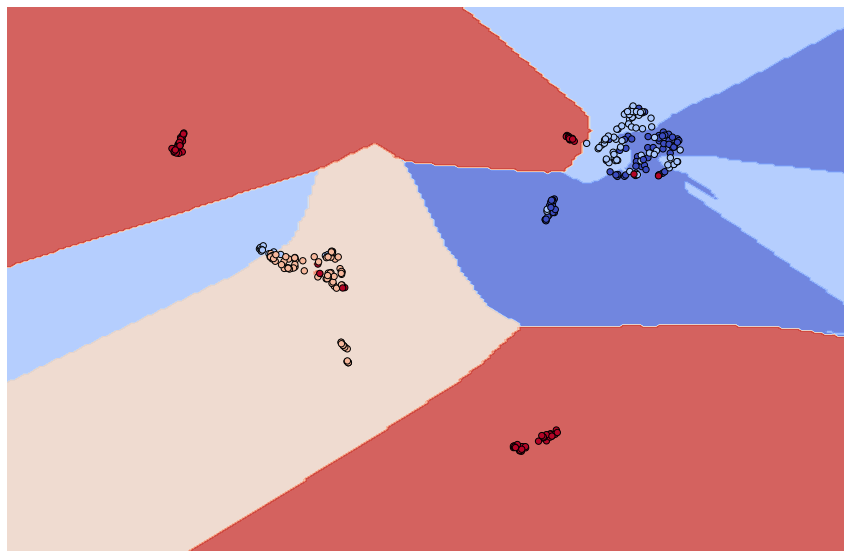

In [ ]:
plot_results(smote_features, smote_targets, clf_knn, figsize=(15, 10))

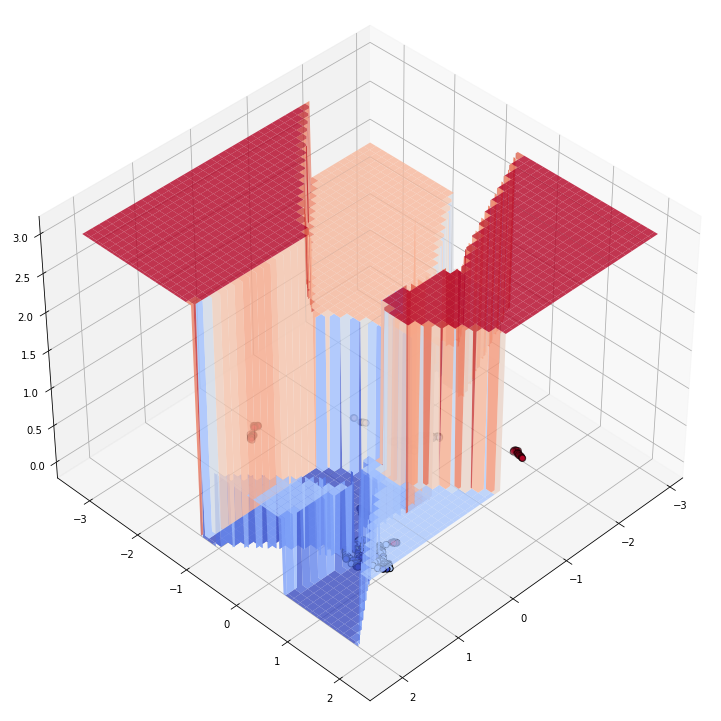

In [ ]:
plot_results(smote_features, smote_targets, clf_knn, in3d=True, figsize=(13, 13), rot=45, axis='on')

# RandomForest

In [ ]:
rf_parameters = {
    'n_estimators': np.linspace(5, 50, 10, dtype=np.int32),
    'criterion': ['gini', 'entropy'],
    'max_depth': np.linspace(5, 10, 5, dtype=np.int32),
}

clf_rf = GridSearchCV(RandomForestClassifier(), rf_parameters)

In [ ]:
clf_rf.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 5,  6,  7,  8, 10]),
                         'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])})

In [ ]:
clf_rf.best_params_

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 45}

In [ ]:
print(classification_report(y_train, clf_rf.predict(x_train), digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      1.000     0.981     0.990        53
           1      0.981     1.000     0.991        53
           2      0.981     1.000     0.991        53
           3      1.000     0.981     0.990        53

    accuracy                          0.991       212
   macro avg      0.991     0.991     0.991       212
weighted avg      0.991     0.991     0.991       212



In [ ]:
print(classification_report(y_test, clf_rf.predict(x_test), digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.842     0.696     0.762        23
           1      0.720     0.783     0.750        23
           2      0.852     1.000     0.920        23
           3      1.000     0.913     0.955        23

    accuracy                          0.848        92
   macro avg      0.853     0.848     0.847        92
weighted avg      0.853     0.848     0.847        92



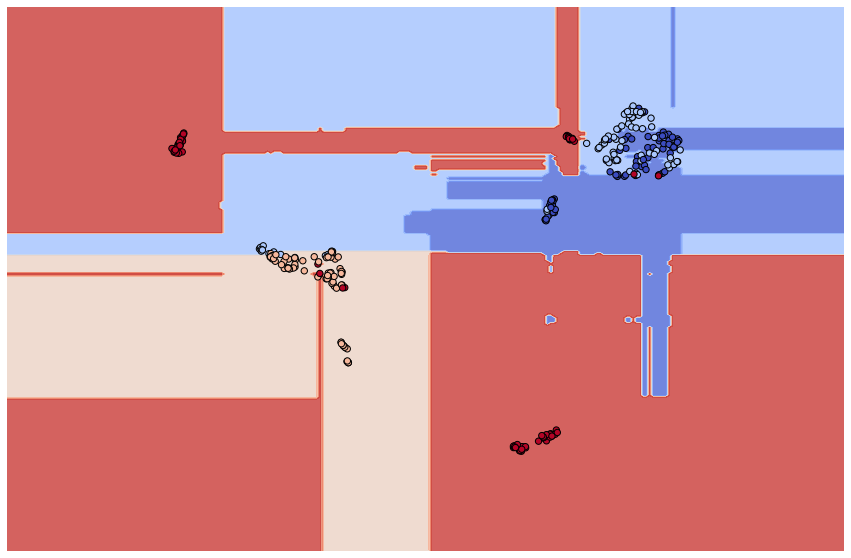

In [ ]:
plot_results(smote_features, smote_targets, clf_rf, figsize=(15, 10))

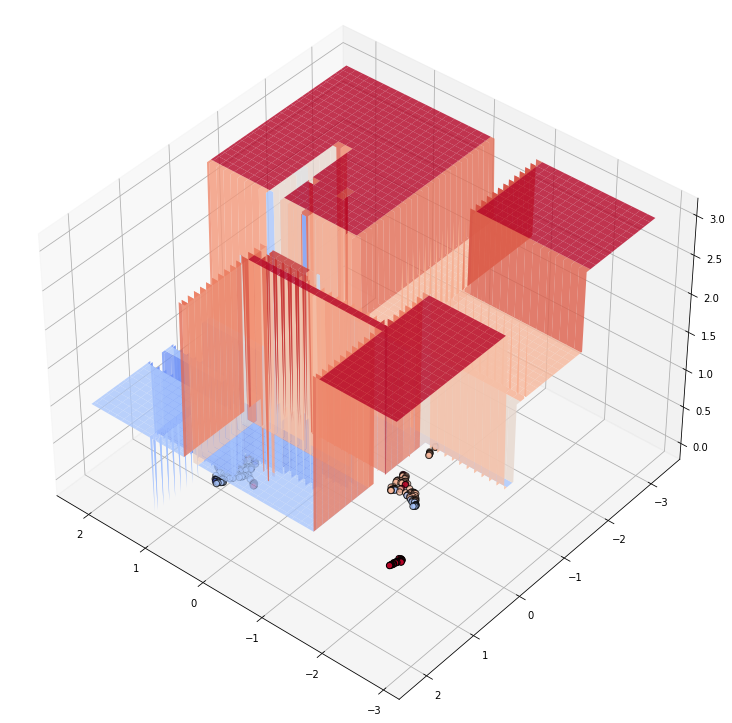

In [ ]:
plot_results(smote_features, smote_targets, clf_rf, in3d=True, figsize=(13, 13), axis='on', rot=130)

# Compare

In [ ]:
def plot_bars(features, targets):
    svc_accuracy = round(accuracy_score(targets, best_svc.predict(features)) * 100, 1)
    knn_accuracy = round(accuracy_score(targets, clf_knn.predict(features)) * 100, 1)
    rf_accuracy = round(accuracy_score(targets, clf_rf.predict(features)) * 100, 1)

    svc_precision = round(precision_score(targets, best_svc.predict(features), average='macro') * 100, 1)
    knn_precision = round(precision_score(targets, clf_knn.predict(features), average='macro') * 100, 1)
    rf_precision = round(precision_score(targets, clf_rf.predict(features), average='macro') * 100, 1)

    svc_f1 = round(f1_score(targets, best_svc.predict(features), average='macro') * 100, 1)
    knn_f1 = round(f1_score(targets, clf_knn.predict(features), average='macro') * 100, 1)
    rf_f1 = round(f1_score(targets, clf_rf.predict(features), average='macro') * 100, 1)

    svc_recall = round(recall_score(targets, best_svc.predict(features), average='macro') * 100, 1)
    knn_recall = round(recall_score(targets, clf_knn.predict(features), average='macro') * 100, 1)
    rf_recall = round(recall_score(targets, clf_rf.predict(features), average='macro') * 100, 1)

    labels = ['accuracy', 'precision', 'recall', 'f1']
    svc_metrics = [svc_accuracy, svc_precision, svc_recall, svc_f1]
    knn_metrics = [knn_accuracy, knn_precision, knn_recall, knn_f1]
    rf_metrics = [rf_accuracy, rf_precision, rf_recall, rf_f1]

    x = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots()

    fig.set_size_inches(12, 5)

    svc_bar = ax.bar(x-width-0.01, svc_metrics, width, label='SVC')
    knn_bar = ax.bar(x, knn_metrics, width, label='KNN')
    rf_bar = ax.bar(x+width+0.01, rf_metrics, width, label='RF')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores, %')
    ax.set_title('Scores for SVC, KNN, RF')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
            fancybox=True, shadow=True, ncol=3)

    ax.bar_label(svc_bar)
    ax.bar_label(knn_bar)
    ax.bar_label(rf_bar)

    fig.tight_layout()

    plt.show()

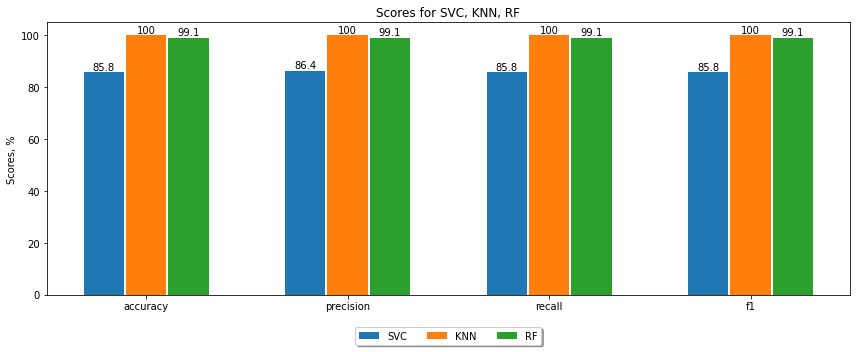

In [ ]:
plot_bars(x_train, y_train)

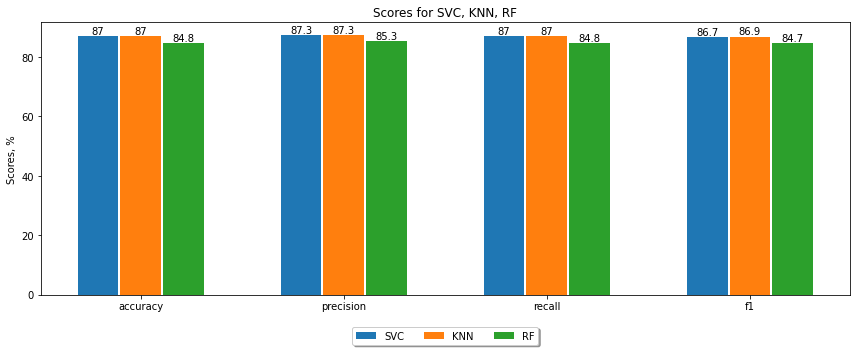

In [ ]:
plot_bars(x_test, y_test)